In [1]:
import keras
import numpy as np
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

# with a little help from https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d


Using TensorFlow backend.


In [2]:

# dimensions of our images
img_width, img_height = 150, 150

# Data sources. Classes should be in their own subdirectories
# We use the full kaggle dataset from their cats and dogs competition
train_data_dir = 'train'
validation_data_dir = 'data/validation'

# Hyperparameters
nb_train_samples = 1024
nb_validation_samples = 400
nb_epoch = 30


In [3]:
# Set up the model structure
import tensorflow as tf


model = keras.models.Sequential()
model.add(Convolution2D(32,3,3, input_shape=(img_width, img_height,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(32,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(128,3,3)) 
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

#model.add(Activation('sigmoid'))


    
# Set the loss function and optimiser
model.compile(loss='binary_crossentropy', optimizer='rmsprop',metrics=['accuracy'])



In [7]:
#### TRAINING... or skip to the next cell and just load the weights
# Setting this function fuzzes the data to help avoid overtraining
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=64,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=64,
        class_mode='categorical')

tf.Session(config=tf.ConfigProto(log_device_placement=True))

# this is where the training happens
model.fit_generator(
        train_generator,
        samples_per_epoch=nb_train_samples,
        nb_epoch=nb_epoch,
        validation_data=validation_generator,
        nb_val_samples=nb_validation_samples)

# save our model so we don't need to run it every time
model.save_weights('more_layers.h5')

Found 25000 images belonging to 2 classes.
Found 802 images belonging to 2 classes.
Epoch 1/30
1024/1024 [==============================] - 14s - loss: 0.5991 - acc: 0.6875 - val_loss: 0.5719 - val_acc: 0.7098

In [4]:
# load our model...if we have already saved it
model.load_weights('more_layers.h5')



cat dog  [ 0.2775436   0.72307092]


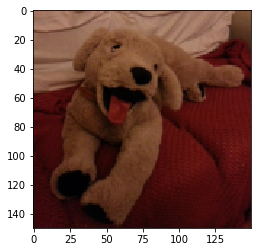

In [7]:
# Run against a test picture

import scipy
import matplotlib.pyplot as plt

%matplotlib inline

# Load image and preprocess for the neural network
img = scipy.misc.imread('IMG_20170219_174243.jpg',mode='RGB')
img = scipy.misc.imresize(img, size=(150,150))
x = np.asarray(img, dtype='float32')
x = x / 255
x = np.expand_dims(x, axis=0)

# Plot it
plt.imshow(img)

# Cat-egorise it.
out1 = model.predict(x)
print 'cat dog ' , out1[0]



convolution2d_1


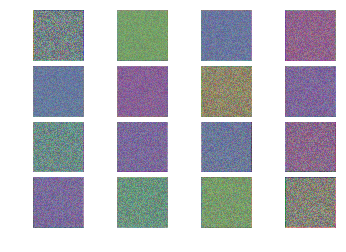

convolution2d_2


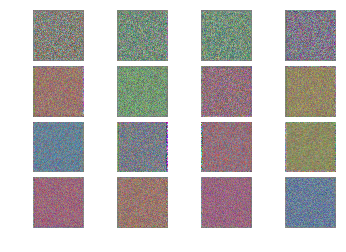

convolution2d_3


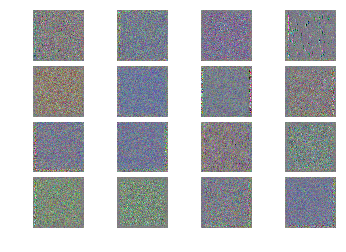

convolution2d_4


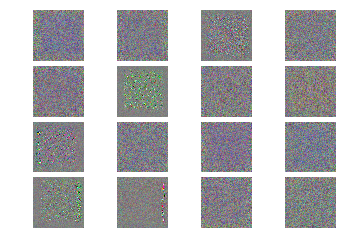

In [19]:
# VISUALISE FILTERS
# From https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

from keras import backend as K
import numpy as np


# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


img_data = model.input


def plot_filters(filtername):
    for filter_index in range(0,16):

        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        layer_output = layer_dict[layer_name].output

        #loss = K.mean(layer_output[:, filter_index, :, :])
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, img_data)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([img_data], [loss, grads])

        # we start from a gray image with some noise
        input_img_data = np.random.random((1,img_width, img_height, 3)) * 20 + 128.

    #    img = scipy.misc.imread('IMG_20170219_174243.jpg',mode='RGB')
    #    img = scipy.misc.imresize(img, size=(150,150))
    #    x = np.asarray(img, dtype='float32')
    #    x = np.expand_dims(x, axis=0)
    #    input_img_data = x


        step = 1



        # run gradient ascent for 20 steps
        for i in range(20):

            loss_value, grads_value = iterate([input_img_data])
            input_img_data += grads_value * step

        img = input_img_data[0]

        #Plot the filter in a 4x4 grid
        plt.subplot(4,4,filter_index+1)
        plt.axis('off')
        plt.imshow(deprocess_image(input_img_data[0]))

    plt.subplots_adjust(wspace=0.01, hspace=0.1)
    plt.show()




layer_dict = dict([(layer.name, layer) for layer in model.layers])
layer_name = 'convolution2d_1'
print(layer_name)
plot_filters(layer_name)

layer_name = 'convolution2d_2'
print(layer_name)
plot_filters(layer_name)

layer_name = 'convolution2d_3'
print(layer_name)
plot_filters(layer_name)

layer_name = 'convolution2d_4'
print(layer_name)
plot_filters(layer_name)



In [16]:
from resnet50 import ResNet50
from keras.preprocessing import image
from imagenet_utils import preprocess_input, decode_predictions

model2 = ResNet50(weights='imagenet')

img_path = 'IMG_20170219_174243.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model2.predict(x)
print 'Predicted:', decode_predictions(preds)


K.image_dim_ordering: tf
Predicted: [[(u'n04399382', u'teddy', 0.75404459), (u'n02808304', u'bath_towel', 0.026833456), (u'n03125729', u'cradle', 0.018716849), (u'n03131574', u'crib', 0.018258924), (u'n04033995', u'quilt', 0.01770781)]]
